# Prestige Bias model

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from numba import jit
from scipy import interpolate
from scipy import optimize
from scipy import special
from scipy import signal
import random
import scipy.stats as st
import gc
from scipy.integrate import quad 

In [2]:
N = 10000 # generation size
A = np.random.normal(0, 1, size=N)
A.shape

(10000,)

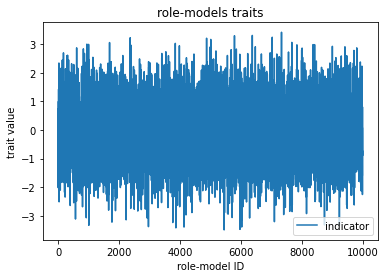

In [3]:
plt.plot(A,label='indicator')
plt.xlabel('role-model ID')
plt.ylabel('trait value')
plt.title('role-models traits')
plt.legend()
plt.show()

In [4]:
b,J = 1,1
A_hat = 1
alpha = 0.5

print(f'b={b}\tJ={J}\tA_hat={A_hat}\t alpha={alpha:.2f}')


b=1	J=1	A_hat=1	 alpha=0.50


In [5]:
def bias(traits,b=b,J=J,A_hat=A_hat):
    return b * np.exp(-(((A_hat - traits) ** 2) / (2*J)))

def probability_err(p,n):
    return 2*1.96*np.sqrt((p*(1-p))/n)

def influence_bias(traits,b,J,success_correlated=True):
    inf_bias = bias(traits,b,J)
    return inf_bias if success_correlated else (1-inf_bias)
    
def is_converging(mean,var,conv_val=A_hat,mean_tol=0.01,var_tol=0.007):
    return np.abs(mean-conv_val) <= mean_tol and var <= var_tol

def mean_distance_from_opt(arr,opt=A_hat):
    return ((arr-opt)**2).mean()

def get_convergence_index(arr,n=5):
    count = 0
    for index,val in enumerate(arr):
        if val:
            count += 1
        else:
            count = 0
        if count == n:
            return index-n   
    

def plot_model(data):
    fig, ax = plt.subplots()
    binary = len(data.shape)==1

    if binary:
        data = data[~np.isnan(data)]
        
        window = min(len(data),51)
        window = window - 1 if window%2 == 0 else window
        
        smoothed_data = signal.savgol_filter(data,window,5)
        
        ax.plot(range(len(data)),smoothed_data,label='indicator freq')
    else:
        ax.plot((0,len(data.shape[1])),(A_hat,A_hat),label='A_hat',linestyle='--')

    plt.legend()

## Dirichlet Approximation Model

In [6]:
@jit(nopython=True)
def make_array_from_copiers(K,original):
    new_arr = np.zeros(len(K))
    i=0
    for index,copiers in enumerate(K):
        for _ in range(int(copiers)):
            new_arr[i]= original[index]
            i= i+ 1
    return new_arr        
            

In [7]:
def prestige_dirichlet(A_,m=1000,binary=False,mutation_scale=0,
                       b=b,J=J,alpha=0.5,A_hat=A_hat,conv_tol=0):
    np.random.seed()
    if binary:
        p = np.empty(m)
    else:    
        p = np.empty((2,m))
    p[:] = np.nan
    
    i=0
    while True:
        if binary and not np.isnan(p[-1]):
            addition = np.empty(m)
            addition[:] = np.nan
            p = np.array(list(p)+ list(addition))
        if binary:
            p[i]=len(A_[A_==A_hat])/len(A_)
        else:
            p[0,i]=A_.mean()
            p[1,i]=A_.var()
        
        A_converge = (np.abs(A_-A_[0]) <= conv_tol).all()
        if A_converge:
            break
        
        if mutation_scale > 0 and not binary:
            A_ += np.random.normal(0, scale = mutation_scale, size=len(A_))
        
        alpha_tag = alpha/(1-alpha)
        prestige = bias(A_,b,J,A_hat)*alpha_tag
        
        dist = np.random.dirichlet(prestige)
        K = np.random.multinomial(len(A_),dist)
        A_ = make_array_from_copiers(K,A_)
        i += 1
    
    return p

### Test binary model

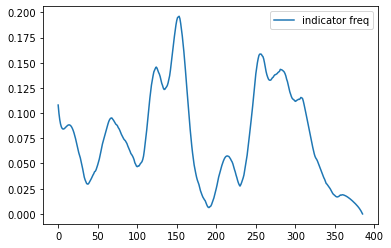

In [8]:
A_ = np.zeros(1000)
A_[:100] = A_hat
A_[A_==0] = A_hat*0.99
data = prestige_dirichlet(A_,binary=True,J=1)
plot_model(data)

## GT model

### Binary model

In [9]:
def binary_GT_model(A_,m=1000,b=b,J=J,alpha=alpha,A_hat=A_hat,conv_tol=0):
    np.random.seed()
    
    p = np.empty(m)
    p[:] = np.nan
    
    i = 0
    while True:
        if not np.isnan(p[-1]):
            addition = np.empty(m)
            addition[:] = np.nan
            p = np.array(list(p)+ list(addition))
        
        p[i]=len(A_[A_==A_hat])/len(A_)
        
        A_converge = (np.abs(A_-A_[0]) <= conv_tol).all()
        if A_converge:
            break
            
        biased_A = bias(A_,b,J)*alpha
        new_A = []
        copiers = np.random.rand(len(A_))
        K = np.zeros(len(A_))
        for j in range(len(A_)):
            prestige = biased_A + (1-alpha)*K
            prestige /= prestige.sum()
            chosen_role_model = np.searchsorted(prestige.cumsum(),copiers[j])
            K[chosen_role_model] += 1
            new_A.append(A_[chosen_role_model])
        A_ = np.array(new_A)
        i+=1
        
    return p

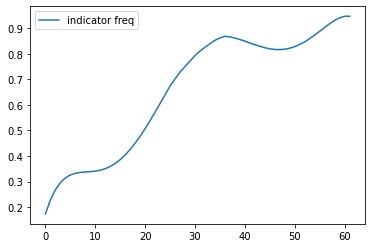

In [10]:
A_ = np.zeros(100)
A_[:20] = A_hat
A_[A_==0] = A_hat - 1e-8
data = binary_GT_model(A_,J=1)
plot_model(data)

### Continous model

# Parallel computing

In [11]:
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import as_completed
from functools import partial


def compute_model_parallel(A_,model,reps=100,max_workers=None):
    futures = []
    with ProcessPoolExecutor(max_workers) as executor:
        for _ in range(int(reps)):
            f = executor.submit(model,A_.copy())
            futures.append(f)

    results = []
    for data in as_completed(futures): 
        results.append(data.result())
    
    return results 

def gt_binary_model_parallel(A_,reps=100,b=b,J=J,alpha=alpha,max_workers=10):
    fixed_model = partial(binary_GT_model,b=b,J=J,alpha=alpha,A_hat=A_hat)
    return compute_model_parallel(A_,fixed_model,reps,max_workers=max_workers)
    
def dirichlet_model_parallel(A_,reps=100,binary=True,mutation_scale=0,conv_tol=0,b=b,J=J,alpha=alpha
                             ,max_workers=10):
    fixed_model = partial(prestige_dirichlet,binary=binary,mutation_scale=mutation_scale,
                          conv_tol=conv_tol,b=b,J=J,alpha=alpha)
    return compute_model_parallel(A_,fixed_model,reps,max_workers=max_workers) 

## Continous model results aggregation

### Test Dirichlet model

# Binary model

In [12]:
def aggregate_binary_model_with_errors(res,A_hat,sample_size):
    fixation_count = 0
    fixation_gens = []
    mean_growth_rate = 0
    diffs = []
    for arr in res:
        arr = arr[~np.isnan(arr)]
        if arr[-1]==A_hat:
            fixation_count += 1
            fixation_gens.append(len(arr))
            
            diff = np.diff(arr).mean()
            diffs.append(diff)
        
    fixation_gens = np.array(fixation_gens)
    fixation_prob = fixation_count/len(res)
    if fixation_prob == 0:
        fixation_prob_err = 0
        fixation_gen_mean = 0
        fixation_gen_err = 0
        mean_growth_rate = 0
    else:    
        fixation_prob_err = probability_err(fixation_prob,sample_size)
        fixation_gen_mean = fixation_gens.mean()
        fixation_conf = st.t.interval(0.95, len(fixation_gens)-1, loc=fixation_gen_mean, scale=st.sem(fixation_gens))
        fixation_gen_err = (fixation_conf[1] - fixation_conf[0])/2
        mean_growth_rate = np.array(diffs).mean()
    
    return fixation_prob,fixation_prob_err,fixation_gen_mean,fixation_gen_err,mean_growth_rate

## Kimura's equations

In [13]:
def kimura(p0,s,N):
    numer = 1 - np.exp(-2*s*N*p0)
    denom = 1 - np.exp(-2*s*N)
    return numer/denom
    
# only for p0=0.5
def kimura_reversed(pi,N):
    return np.log(-pi/(pi-1))/(4*N*p0)


def effective_population(N,alpha):
    return alpha*N + (1-alpha)
    

def durret(x,alpha,beta,N):
    Ne = effective_population(N,alpha)
    numer = 1 - np.exp(-2*(1-beta)*Ne*x)
    denom = 1 - np.exp(-2*(1-beta)*Ne)
    return numer/denom

In [14]:
def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0]


def I1(N, s, x):
    if x == 1:
        return 0
    return (1 - np.exp(-2*N*s*x) - np.exp(-2 * N * s * (1 - x)) + np.exp(-2 * N *s)) / (x*(1-x))


def I2(N, s, x):
    if x == 0:
        return 0
    return -np.expm1(2 * N * s * x) * np.expm1(-2 * N * s * x) / (x * (1 - x))


@np.vectorize
def T_kimura(n0, N, s):
    x = n0 / N
    J1 = -1.0 / (s * np.expm1(-2 * N * s)) * integral(I1, N, s, x, 1)
    u = np.expm1(-2 * N * s * x) / np.expm1(-2 * N * s)
    J2 = -1.0 / (s * np.expm1(-2 * N *s)) * integral(I2, N, s, 0, x)
    return J1 + ((1 - u) / u) * J2

## Test models

### Test Dirichlet model

In [15]:
N = 1000
p0 = 1e-3
A = A_hat*0.7
alpha = 0.2
J=1
A_ = np.zeros(N)
A_[:int(p0*N)] = A_hat
A_[A_==0] = A
beta = bias(A,J=J,A_hat=A_hat)
results = dirichlet_model_parallel(A_,reps=10000,binary=True,J=J,alpha=alpha,max_workers=60)

aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
fixation_prob,fixation_prob_err,fixation_gen_mean,fixation_gen_err,growth_rate = aggregated_results

print(f'fixation probability and estimated error: {fixation_prob} \t {fixation_prob_err}')
print(f'durret probability: {durret(p0,alpha,beta,N):.4f}')
print(f'fixation growth rate and mean fixation time:{growth_rate:.4f} \t {fixation_gen_mean}')
print(f'beta:{beta:.4f}')

fixation probability and estimated error: 0.0174 	 0.00512565145845872
durret probability: 0.0175
fixation growth rate and mean fixation time:0.0074 	 149.3735632183908
beta:0.9560


### Test Wright-Fisher fixation probability

In [16]:
def wf_fix_prob(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    n[:] = n0 # broadcasting
    update = (n > 0) & (n < N)
    while update.any():
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)
    return (n == N).mean()


N = 10000
s = 1e-3
p0 = 1e-4
reps = 10000
n0 = p0*N

p = wf_fix_prob(n0, N, s, reps)
print(f'fixation probability and probability error: {p}\t{probability_err(p,N):.4f}')
print(f'kimura probability: {kimura(p0,s,N):.4f}')

fixation probability and probability error: 0.0018	0.0017
kimura probability: 0.0020


### Test Wright-Fisher fixation time

In [17]:
def wf_fix_time_with_err(results):
    is_fixed,times = results
    fixation_gens = times[is_fixed]
    fixation_gen_mean = fixation_gens.mean()
    fixation_conf = st.t.interval(0.95, len(fixation_gens)-1, loc=fixation_gen_mean, scale=st.sem(fixation_gens))
    fixation_gen_err = (fixation_conf[1] - fixation_conf[0])/2
    
    return fixation_gen_mean,fixation_gen_err
    


def wf_fix_time_sim(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    T = np.repeat(np.inf, repetitions)
    
    t = 0
    n[:] = n0
    update = (n > 0) & (n < N)
    while update.any():        
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)
        t += 1
        T[~update] = np.minimum(T[~update], t)
    return n == N, T


N = effective_population(1000,0.2)
s = 1-0.956
p0 = 1e-4
reps = 10000
n0 = p0*N
t,t_err = wf_fix_time_with_err(wf_fix_time_sim(n0, N, s, reps))
print(f'fixation time and error: {t:.2f}\t\t\t{t_err:.4f}')
print(f'kimura fixation time: {T_kimura(n0, N, s):.4f}')

fixation time and error: 155.25			22.1588
kimura fixation time: 154.0194


## Compare DM vs WF

### Variating $\alpha$

In [18]:
alphas = np.linspace(start=1e-4,stop=0.999,num=30)
N = 1000
p0 = 1e-3
A = A_hat*0.7
A_ = np.zeros(N)
A_[:int(p0*N)] = A_hat
A_[A_==0] = A
beta = bias(A,J=J,A_hat=A_hat)

sim_res_alpha = []
for alpha in alphas:
    results = dirichlet_model_parallel(A_,binary=True,reps=10000,J=J,alpha=alpha,max_workers=60)

    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    fixation_prob,fixation_prob_err,fix_time,fix_time_err,_ = aggregated_results
    
    durr = durret(p0,alpha,beta,N)
    
    sim_res_alpha.append((fixation_prob,fixation_prob_err,durr,fix_time,fix_time_err))

In [19]:
wf_res_alpha = []
s = 1-beta
for alpha in alphas:
    Ne = effective_population(N,alpha)
    n0 = p0*Ne
    p = wf_fix_prob(n0, Ne, s, reps)
    p_err = probability_err(p,reps)
    t,t_err = wf_fix_time_with_err(wf_fix_time_sim(n0, Ne, s, reps))
    kim = T_kimura(n0, Ne, s)
    wf_res_alpha.append((p,p_err,t,t_err,kim,Ne))

/home/medaware/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/medaware/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


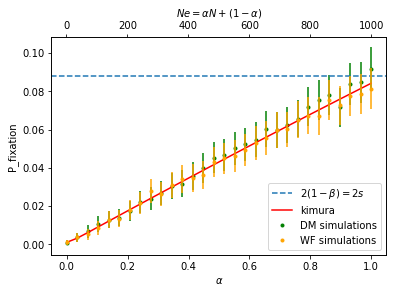

In [20]:
Y = [tup[0] for tup in sim_res_alpha]
Y_err = [tup[1] for tup in sim_res_alpha]
durrs = [tup[2] for tup in sim_res_alpha]

Y_wf = [tup[0] for tup in wf_res_alpha]
Y_wf_err = [tup[1] for tup in wf_res_alpha]
Nes = [tup[-1] for tup in wf_res_alpha]

ax1 = plt.gca()
ax2 = ax1.twiny()

ax1.set_xlabel(r'$\alpha$')
ax2.set_xlabel(r'$Ne=\alpha N + (1-\alpha)$')
ax1.set_ylabel(r'P_fixation')
l1 = ax1.axhline(2*(1-beta), ls='--', label=r'$2(1-\beta) = 2s$')
l2 = ax1.plot(alphas,durrs,label= 'kimura',zorder=2,color='r')
l3 = ax1.errorbar(alphas,Y,yerr=Y_err,fmt='o',color='green',markersize=3,zorder=1)
l4 = ax2.errorbar(Nes,Y_wf,yerr=Y_wf_err,fmt='o',color='orange',zorder=0,markersize=3);

lns = (l1,l2[0],l3[0],l4[0])
labs = [l1.get_label(),l2[0].get_label(),'DM simulations','WF simulations']
plt.legend(lns, labs, loc=4);
plt.savefig('../graphs/fix_prob_var_alpha.pdf')

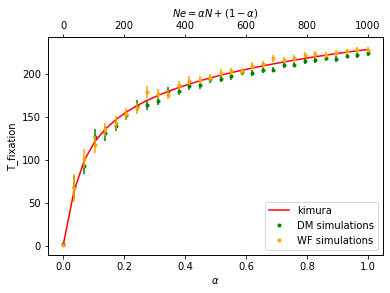

In [21]:
Y = [tup[3] for tup in sim_res_alpha]
Y_err = [tup[4] for tup in sim_res_alpha]

Y_wf = [tup[2] for tup in wf_res_alpha]
Y_wf_err = [tup[3] for tup in wf_res_alpha]
kims = [tup[4] for tup in wf_res_alpha]

ax1 = plt.gca()
ax2 = ax1.twiny()

ax1.set_xlabel(r'$\alpha$')
ax2.set_xlabel(r'$Ne=\alpha N + (1-\alpha)$')
ax1.set_ylabel(r'T_fixation')
l1 = ax1.plot(alphas,kims,label= 'kimura',zorder=2,color='r')
l2 = ax1.errorbar(alphas,Y,yerr=Y_err,fmt='o',color='green',markersize=3,zorder=1)
l3 = ax2.errorbar(Nes,Y_wf,yerr=Y_wf_err,fmt='o',color='orange',zorder=0,markersize=3);

lns = (l1[0],l2[0],l3[0])
labs = [l1[0].get_label(),'DM simulations','WF simulations']
plt.legend(lns, labs, loc=4);
plt.savefig('../graphs/fix_time_var_alpha.pdf')

### Varying $\beta$

In [22]:
trait_modifiers = np.linspace(start=0.01,stop=0.99,num=30)
N = 1000
alpha = 0.01
p0 = 1e-3
sim_res_beta = []
for mod in trait_modifiers:
    A = A_hat*mod
    beta = bias(A,J=J,A_hat=A_hat)
    
    A_ = np.zeros(N)
    A_[:int(p0*N)] = A_hat
    A_[A_==0] = A
    results = dirichlet_model_parallel(A_,binary=True,reps=10000,J=J,alpha=alpha,max_workers=60)

    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    fixation_prob,fixation_prob_err,fix_time,fix_time_err,_ = aggregated_results
    
    durr = durret(p0,alpha,beta,N)
    
    sim_res_beta.append((fixation_prob,fixation_prob_err,durr,fix_time,fix_time_err,beta))

In [23]:
neg_betas = 1 - np.array([tup[-1] for tup in sim_res_beta])
Ne = effective_population(N,alpha)
wf_res_s = []

for s in neg_betas:
    n0 = p0*Ne
    p = wf_fix_prob(n0, Ne, s, reps)
    p_err = probability_err(p,reps)
    t,t_err = wf_fix_time_with_err(wf_fix_time_sim(n0, Ne, s, reps))
    kim = T_kimura(n0, Ne, s)
    wf_res_s.append((p,p_err,t,t_err,kim))

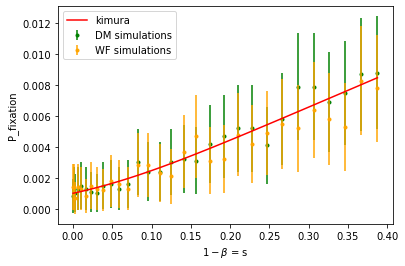

In [24]:
Y = [tup[0] for tup in sim_res_beta]
Y_err = [tup[1] for tup in sim_res_beta]
durrs = [tup[2] for tup in sim_res_beta]

Y_wf = [tup[0] for tup in wf_res_s]
Y_wf_err = [tup[1] for tup in wf_res_s]


plt.xlabel(r'$1-\beta$ = s')
plt.ylabel(r'P_fixation')
plt.plot(neg_betas,durrs,zorder=2,label='kimura',color='r')
plt.errorbar(neg_betas,Y,yerr=Y_err,fmt='o',label='DM simulations',zorder=0,markersize=3,color='g');
plt.errorbar(neg_betas,Y_wf,yerr=Y_wf_err,fmt='o',label='WF simulations',zorder=1,markersize=3,color='orange');

plt.legend(loc=2);
plt.savefig('../graphs/fix_prob_var_beta.pdf')

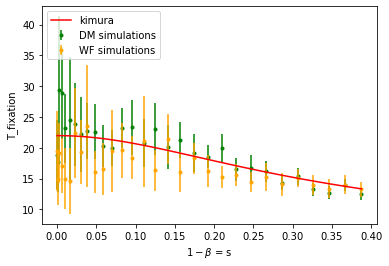

In [25]:
Y = [tup[3] for tup in sim_res_beta]
Y_err = [tup[4] for tup in sim_res_beta]

Y_wf = [tup[2] for tup in wf_res_s]
Y_wf_err = [tup[3] for tup in wf_res_s]
kims = [tup[4] for tup in wf_res_s]


plt.xlabel(r'$1-\beta$ = s')
plt.ylabel(r'T_fixation')
plt.plot(neg_betas,kims,zorder=2,label='kimura',color='r')
plt.errorbar(neg_betas,Y,yerr=Y_err,fmt='o',label='DM simulations',zorder=0,markersize=3,color='g');
plt.errorbar(neg_betas,Y_wf,yerr=Y_wf_err,fmt='o',label='WF simulations',zorder=1,markersize=3,color='orange');

plt.legend(loc=2);
plt.savefig('../graphs/fix_time_var_beta.pdf')

## Compare DM vs full model

In [26]:
def plot_binary_comparison(x_axis,full_res,dm_res,x_name,log_scale=False,kims=None):
    fig, axs = plt.subplots(1, 2,figsize=[10,5])
    listify = lambda x,i: [y[i] for y in x]
    
    axs[0].set_ylabel('probability')
    axs[0].set_xlabel(x_name)
    l1 = axs[0].errorbar(x_axis,listify(full_res,0),yerr=listify(full_res,1),fmt='-o',alpha=0.5)
    l2 = axs[0].errorbar(x_axis,listify(dm_res,0),yerr=listify(dm_res,1),fmt='-*')
    l3 = axs[0].axhline(kims[0], ls='--')

    axs[1].set_ylabel('time/generation')
    axs[1].set_xlabel(x_name)
    axs[1].errorbar(x_axis,listify(full_res,2),yerr=listify(full_res,3),fmt='-o',alpha=0.5)
    axs[1].errorbar(x_axis,listify(dm_res,2),yerr=listify(dm_res,3),fmt='-*')
    axs[1].axhline(kims[1], ls='--')
    for ax in axs.flat:
        if log_scale:
            ax.set_xscale('log')

    fig.legend((l1,l2,l3),('full model','DM model','kimura'))
    fig.tight_layout()

### Number of simulations

In [27]:
num_reps = np.linspace(100,5000,30)
N=1000
alpha=0.5
A_ = np.zeros(N)
J=1
A_[0] = A_hat
A_[A_==0] = A_hat*0.7
beta = bias(A_hat*0.7,J=J)
Ne = effective_population(N,alpha)
kims = (durret(1e-3,alpha,beta,N),T_kimura(1, Ne, 1-beta))
gt_results = []
dm_results = []

for reps in num_reps:
    full_results = gt_binary_model_parallel(A_,reps=reps,J=J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(full_results,A_hat,len(results))
    gt_results.append(aggregated_results)

    results = dirichlet_model_parallel(A_,binary=True,reps=reps,J=J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    dm_results.append(aggregated_results)

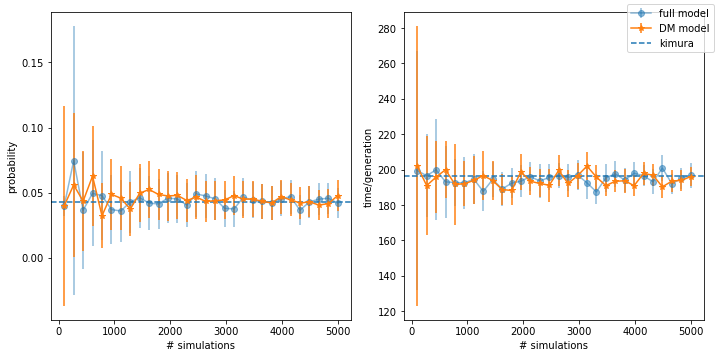

In [28]:
plot_binary_comparison(num_reps,gt_results,dm_results,x_name='# simulations',kims=kims)
plt.savefig('../graphs/num_sims.pdf')

### Mutation

In [29]:
N=1000
alpha=0.1
A_ = np.zeros(N)
A_[0] = A_hat
A_[A_==0] = A_hat*0.7
mutations = np.logspace(-7,-1,30)
reps = 5000
orig_J = 1
gt_results = []
dm_results = []
Ne = effective_population(N,alpha)
beta = bias(A_hat*0.7,J=orig_J)
kims = (durret(1e-3,alpha,beta,N),T_kimura(1, Ne, 1-beta))
for mutation in mutations:
    J = np.random.normal(orig_J, scale = mutation, size=len(A_))
    
    full_results = gt_binary_model_parallel(A_,reps=reps,J=J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(full_results,A_hat,len(results))
    gt_results.append(aggregated_results)

    results = dirichlet_model_parallel(A_,binary=True,reps=reps,J=J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    dm_results.append(aggregated_results)

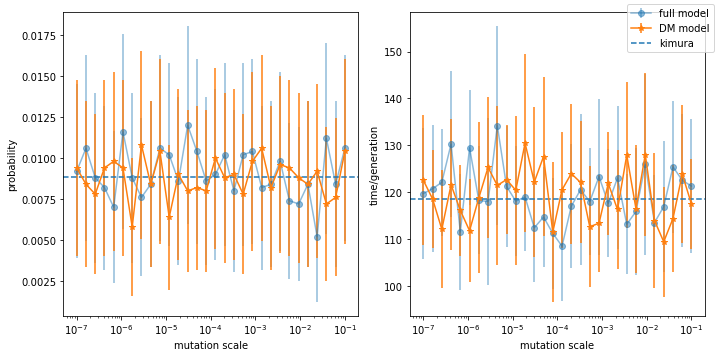

In [30]:
plot_binary_comparison(mutations,gt_results,dm_results,x_name='mutation scale',log_scale=True,kims=kims)
plt.savefig('../graphs/full_vs_dm_mutation.pdf')

### Heterogenous $\alpha$

In [31]:
N=1000
alpha=0.5
A_ = np.zeros(N)
J=1
A_[0] = A_hat
A_[A_==0] = A_hat*0.7
scales = np.logspace(-7,-1,30)
reps = 5000
Ne = effective_population(N,alpha)
beta = bias(A_hat*0.7,J=J)
kims = (durret(1e-3,alpha,beta,N),T_kimura(1, Ne, 1-beta))
gt_results = []
dm_results = []
for scale in scales:
    normal_alpha = np.random.normal(alpha, scale = scale, size=len(A_))
    
    full_results = gt_binary_model_parallel(A_,reps=reps,J=J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(full_results,A_hat,len(results))
    gt_results.append(aggregated_results)

    results = dirichlet_model_parallel(A_,binary=True,reps=reps,J=J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    dm_results.append(aggregated_results)

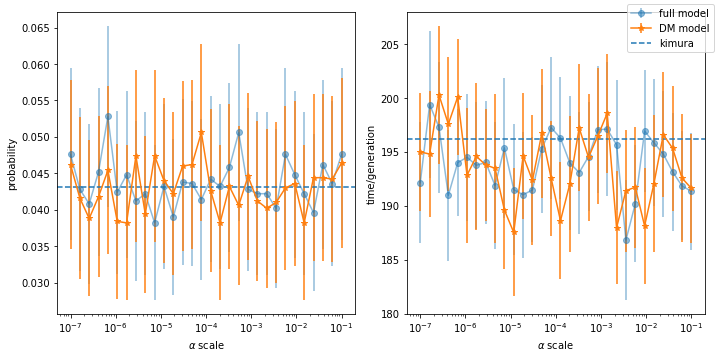

In [32]:
plot_binary_comparison(scales,gt_results,dm_results,x_name=r'$\alpha$ scale',log_scale=True,kims=kims)
plt.savefig('../graphs/full_vs_dm_changing_alpha.pdf')